In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import Rectangle
import cv2
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
import supervision as sv
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from transformers import CLIPTokenizer
from tqdm import tqdm
from detectron2.structures import ImageList

from compile_and_profile.compile_profile_inference_aihub import prepare_data, build_model
from compile_and_profile.models import GroundedSAM, GroundingDino
from compile_and_profile.inference import load_data
from modeling.vision.encoder.transformer_encoder_fpn import TransformerEncoderPixelDecoder
from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor

image_dir = Path('./compile_and_profile/images/default')
annotation_path = Path('./compile_and_profile/annotations/instances_default.json')
output_dir = Path('./compile_and_profile/onnx/output')
coco = COCO(annotation_path)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [6]:
GROUNDING_DINO_CONFIG_PATH = "./Grounded-Segment-Anything//GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "./lpcvc_track2_models/groundingdino_swint_ogc.pth"
grounding_dino_model = GroundingDino(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

SAM_ENCODER_VERSION = "vit_b"
SAM_CHECKPOINT_PATH = "./lpcvc_track2_models/sam_vit_b_01ec64.pth"
sam_model = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH)
sam_predictor = SamPredictor(sam_model)

model = GroundedSAM(grounding_dino_model, sam_model)

final text_encoder_type: bert-base-uncased


In [8]:
image_path = Path('./demo/seem/examples/corgi2.jpg')
text = 'A dog.'
BOX_THRESHOLD = 0.25
TEXT_THRESHOLD = 0.25
NMS_THRESHOLD = 0.8

image_cv2 = cv2.imread(image_path) # (H, W, C)
image_from_cv2 = Image.fromarray(cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB))
transform = transforms.Compose(
        [
            transforms.Resize(1000, max_size=1024),  # Resize longest edge to 1024
        ]
    )
image_from_cv2 = transform(image_from_cv2)
image_cv2 = cv2.cvtColor(np.asanyarray(image_from_cv2), cv2.COLOR_RGB2BGR)

image_input, text_input = prepare_data(image_path, text)
images, tokens, image_input_ = model.pre_processing(image_input, text_input)

In [9]:
output = model(image_input, text_input)

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


Before NMS: 1 boxes
After NMS: 1 boxes


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


In [4]:
data = load_data(14)

100%|██████████| 146/146 [00:03<00:00, 47.67it/s]


In [6]:
idx = -5
output = model(data[idx]['image_input'], data[idx]['text_input'])

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


Before NMS: 0 boxes
After NMS: 0 boxes


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


## DINO and SAM scripts

In [4]:
# m = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)
m = grounding_dino_model
detections = m.predict_with_caption(image=image_input[0], caption=text, box_threshold=BOX_THRESHOLD, text_threshold=TEXT_THRESHOLD)
detections

Detections(xyxy=array([[ 540.37866 ,  391.42526 ,  748.03625 ,  679.5775  ],
       [ 247.25848 ,  375.72134 ,  770.2601  ,  939.9252  ],
       [   4.533844,    4.814728, 1019.4342  , 1019.2706  ]],
      dtype=float32), mask=None, confidence=array([0.29251298, 0.26743627, 0.25959662], dtype=float32), class_id=array([0, 1, 2]), tracker_id=None, data={})

In [5]:
# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{text} {confidence:0.2f}"
    for _, _, confidence, class_id, _, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image_cv2.copy(), detections=detections, labels=labels)
# save the annotated grounding dino image
cv2.imwrite("groundingdino_annotated_image.jpg", annotated_frame)

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


True

In [ ]:
# NMS post process
print(f"Before NMS: {len(detections.xyxy)} boxes")
# nms_idx = torchvision.ops.nms(
#     torch.from_numpy(detections.xyxy),
#     torch.from_numpy(detections.confidence),
#     NMS_THRESHOLD
# ).numpy().tolist()
nms_idx = [1]

detections.xyxy = detections.xyxy[nms_idx]
detections.confidence = detections.confidence[nms_idx]
detections.class_id = detections.class_id[nms_idx]

print(f"After NMS: {len(detections.xyxy)} boxes")

Before NMS: 3 boxes
After NMS: 1 boxes


In [6]:
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

In [7]:
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{text} {confidence:0.2f}"
    for _, _, confidence, class_id, _, _
    in detections]
annotated_image = mask_annotator.annotate(scene=image_cv2.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
# save the annotated grounded-sam image
cv2.imwrite("grounded_sam_annotated_image.jpg", annotated_image)

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


True

## X-Decoder scripts

In [ ]:
# Step 1: Prepare input data
image_path = "./demo/seem/examples/corgi2.jpg"
text = "dog."
image_input, text_input = prepare_data(image_path, text)

# Step 2: Build model
model = build_model(image_input, text_input)

## viewer

In [ ]:
onnx_output_dir = Path('./compile_and_profile/torch/output')
torch_output_dir = Path('./compile_and_profile/onnx/output')

def show_image(image_id: int):
    image = coco.imgs[image_id]
    image_path = "./compile_and_profile/images/default" / Path(f"{image['file_name']}")
    img = np.asarray(Image.open(image_path))
    plt.imshow(img)

def show_image_and_annotation(image_id: int, output_dir):
    image = coco.imgs[image_id]
    image_path = "./compile_and_profile/images/default" / Path(f"{image['file_name']}")
    img = np.asarray(Image.open(image_path))

    for ann_id in coco.getAnnIds([image_id]):
        annotation = coco.anns[ann_id]
        texts = [v for v in annotation['attributes'].values() if isinstance(v, str) and len(v) > 0]
        plt.figure(figsize=(3, 3))
        ax = plt.gca()

        bbox = annotation['bbox']
        box_plot = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(box_plot)
        ax.imshow(img)
        coco.showAnns([annotation])
        for i, text in enumerate(texts):
            plt.figure(figsize=(3, 3))
            ax = plt.gca()
            output_img_path = output_dir / 'images' / f"{image['file_name'].replace(' ', '_')}_{ann_id}_{text.replace(' ', '_')}.jpg"
            output_img = np.asarray(Image.open(output_img_path))
            ax.imshow(output_img)
            ax.set_title(text)




FileNotFoundError: [Errno 2] No such file or directory: 'compile_and_profile/torch/output/images/66910013_3cf3aef994_b.jpg_30_The_grey_keyboard.jpg'

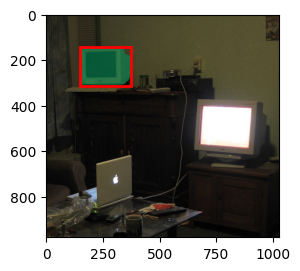

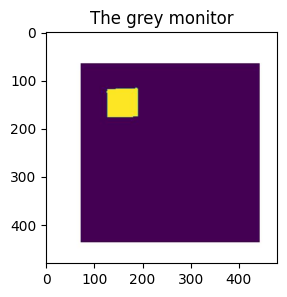

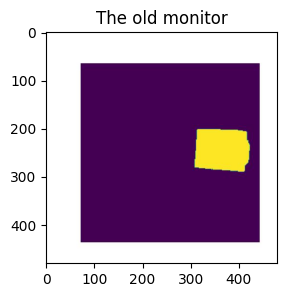

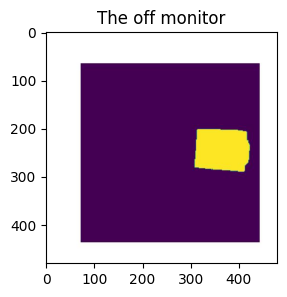

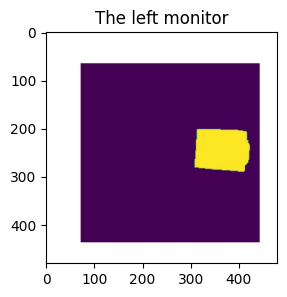

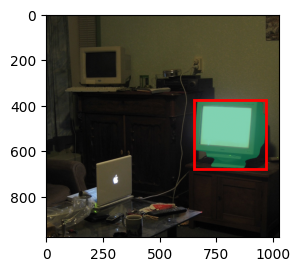

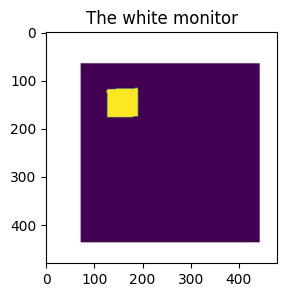

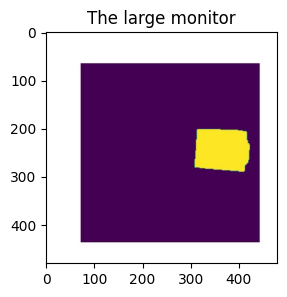

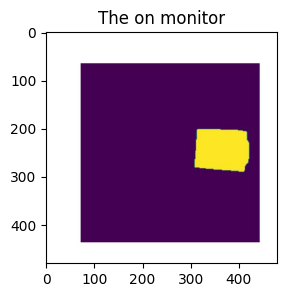

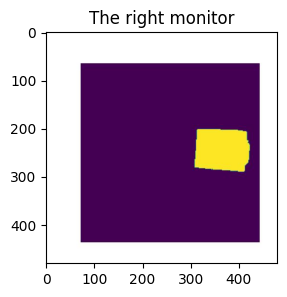

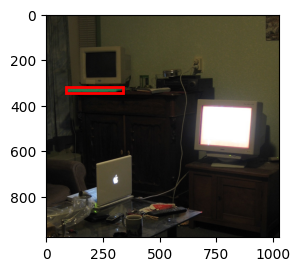

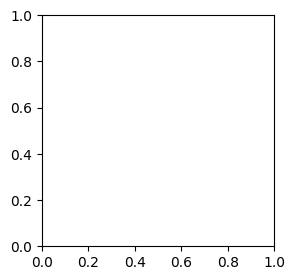

In [37]:
image_id = 14
show_image_and_annotation(image_id, onnx_output_dir)
show_image_and_annotation(image_id, torch_output_dir)